In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import syft as sy
import torchvision.datasets as datasets
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

from IPython.display import clear_output

## Constants

In [28]:
n_workers = 100
n_workers_round = int(n_workers * 0.2)

lr = 0.1
batch_size = 16
test_batch_size = 100

dp_t = 5 # max number of non-colluding parties
dp_eps = 1. # epsilon for (ϵ,δ)-DP
dp_delta = 1e-5 # delta for (ϵ,δ)-DP
dp_clipping = 1.
dp_sigma = 0.1

## Load dataset

In [3]:
def transform(X_mnist):
    return X_mnist.view(-1, 28, 28).float() / 255

In [4]:
def batch_list(l, batch_size):
    return [l[i*batch_size:(i+1)*batch_size] for i in range(int(math.ceil(len(l) / batch_size)))]

In [5]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, 
                             transform=None)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, 
                             transform=transforms.Compose([
                                 transforms.ToTensor()                             
                             ]))

In [6]:
test_loader = torch.utils.data.DataLoader(
    mnist_test,
    batch_size=test_batch_size, shuffle=True)

In [7]:
train_loader = torch.utils.data.DataLoader(
    mnist_train,
    batch_size=test_batch_size, shuffle=True)

In [8]:
n_samples_train_per_worker = len(mnist_train.targets) // n_workers
n_samples_train = len(mnist_train.targets)

n_samples_test_per_worker = len(mnist_test.targets) // n_workers
n_samples_test = len(mnist_test.targets)

## Put data on different workers

### Declare the hook

In [9]:
hook = sy.TorchHook(torch)

### Declare the workers

In [10]:
workers = [sy.VirtualWorker(hook, id=f"bob{i}") for i in range(n_workers)]
crypto_provider = sy.VirtualWorker(hook, id="crypto_provider")

### Move the data

In [11]:
X_train_ptr_worker = [transform(mnist_train.data[n_samples_train_per_worker*i:n_samples_train_per_worker*(i+1)]).send(workers[i]) for i in range(n_workers)]
Y_train_ptr_worker = [mnist_train.targets[n_samples_train_per_worker*i:n_samples_train_per_worker*(i+1)].send(workers[i]) for i in range(n_workers)]

X_test_ptr_worker = [transform(mnist_test.data[n_samples_test_per_worker*i:n_samples_test_per_worker*(i+1)]).send(workers[i]) for i in range(n_workers)]
Y_test_ptr_worker = [mnist_test.targets[n_samples_test_per_worker*i:n_samples_test_per_worker*(i+1)].send(workers[i]) for i in range(n_workers)]

In [12]:
X_test_ptr_worker[0].shape

torch.Size([100, 28, 28])

## Create model

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [20]:
loss_fn = torch.nn.NLLLoss()

## Train the model

In [21]:
lr = 0.1

In [22]:
model = Net()

# We send all initial models to the clients, and never take them back in clear (only for secure aggregation)
model_worker = [model.copy().send(workers[i]) for i in range(n_workers)] # Important: starting from the same initialization

opt_worker = [optim.SGD(params=model_worker[i].parameters(), lr=lr) for i in range(n_workers)]

list_loss_test_worker = [list() for _ in range(n_workers)]

In [23]:
list_loss_test_worker[0:5]

[[], [], [], [], []]

In [34]:
n_rounds = 20
n_local_epochs = 1

for i_round in range(n_rounds):
    sample_indices = list(np.random.permutation(range(n_samples_train_per_worker)))
    list_workers_round = np.random.choice(range(n_workers), n_workers_round, replace=False)
    
    for i_worker, worker_index in enumerate(list_workers_round):
        loss_worker = 0
        i_iter = 0
        
        # Update client        
        for i_local_epoch in range(n_local_epochs):  # n_local_epochs=E
            list_batch_indices = batch_list(sample_indices, batch_size)
            for i_batch, batch_indices in enumerate(list_batch_indices):
                batch_indices_tensor = torch.tensor(batch_indices).send(workers[worker_index])
                X_ptr = X_train_ptr_worker[worker_index][batch_indices, :, :]
                Y_ptr = Y_train_ptr_worker[worker_index].gather(0, batch_indices_tensor)

                pred = model_worker[worker_index](X_ptr)
                loss = loss_fn(pred, Y_ptr)

                opt_worker[worker_index].zero_grad()
                loss.backward()
                opt_worker[worker_index].step()

#                 model_worker[worker_index] = model_worker[worker_index].get()
                loss_worker += loss.get().data.numpy()
#                 model_worker[worker_index].get()
                i_iter += 1

                clear_output(wait=True)
                print(f"Round {i_round + 1}/{n_rounds}")
                print(f"Worker {i_worker+1}/{n_workers_round}")
                print(f"Batch {i_batch} / {len(mnist_train.data) // n_workers // batch_size}: {loss_worker / (i_iter):.4f}")
                if i_round >= 1:
                    print(f"Test loss {np.mean(list_loss_test_worker, axis=0)[-1]:.4f}")
                del batch_indices_tensor
    
    # Update global model
    print("Update...")
    with torch.no_grad():
        new_param = [0.] * len(list(model_worker[0].parameters()))
        for i_param, param_worker in enumerate(zip(*(model_worker[i].parameters() for i in range(n_workers)))):
            print(f"{i_param} ", end="\r")
            for i_worker in list_workers_round:
                new_param[i_param] += param_worker[i_worker].copy().get().fix_precision().share(*workers, crypto_provider=crypto_provider)
            new_param[i_param] = new_param[i_param].get().float_precision() / n_workers_round
               
        for i_worker in range(n_workers):
            model_worker[i_worker].get()
            for i_param, param in enumerate(model_worker[i_worker].parameters()):
                param.set_(torch.tensor(new_param[i_param]))
            model_worker[i_worker].send(workers[i_worker])
            

    # Test clients
    print("Test...")
    for i_worker in range(n_workers):
        X_ptr = X_test_ptr_worker[i_worker]
        Y_ptr = Y_test_ptr_worker[i_worker]
        pred = model_worker[i_worker](X_ptr)
        test_loss = loss_fn(pred, Y_ptr).get().data.numpy()
        list_loss_test_worker[i_worker].append(test_loss)
#         model_worker[worker_index] = model_worker[worker_index].get()

0


RuntimeError: Expected 4-dimensional input for 4-dimensional weight 20 1 5 5, but got 1-dimensional input of size [0] instead

## Test global model

In [25]:
for i_worker in range(n_workers):
    model_worker[i_worker].get()

model_worker[0].eval()
correct = 0
for X, Y in test_loader:
    output = model_worker[0](X)
    pred = output.argmax(1, keepdim=True)
    correct += pred.eq(Y.view_as(pred)).sum().item()

print('Accuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Accuracy: 9758/10000 (98%)



## Plots

### Learning curves

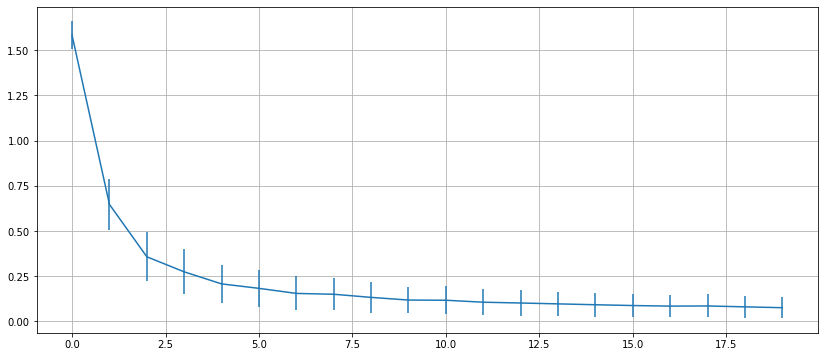

In [142]:
plt.rcParams['figure.figsize'] = (14, 6)

plt.errorbar(range(n_rounds), np.mean(list_loss_test_worker, axis=0), np.std(list_loss_test_worker, axis=0))
plt.grid()
# plt.scatter(range(n_rounds), np.mean(list_loss_test_worker, axis=0))

## Clean everything (in case)

In [116]:
for i in range(n_workers):
    workers[i].clear_objects()

In [117]:
X_train_ptr_worker = [transform(mnist_train.data[n_samples_train_per_worker*i:n_samples_train_per_worker*(i+1)]).send(workers[i]) for i in range(n_workers)]
Y_train_ptr_worker = [mnist_train.targets[n_samples_train_per_worker*i:n_samples_train_per_worker*(i+1)].send(workers[i]) for i in range(n_workers)]

X_test_ptr_worker = [transform(mnist_test.data[n_samples_test_per_worker*i:n_samples_test_per_worker*(i+1)]).send(workers[i]) for i in range(n_workers)]
Y_test_ptr_worker = [mnist_test.targets[n_samples_test_per_worker*i:n_samples_test_per_worker*(i+1)].send(workers[i]) for i in range(n_workers)]

In [118]:
model = Net()
model_worker = [model.copy().send(workers[i]) for i in range(n_workers)] # Important: starting from the same initialization

In [97]:
# bob = sy.VirtualWorker(hook, id="bob")

# a = torch.tensor([10,20,30])
# print(a[[0,2]])

# b = torch.tensor([10,20,30]).send(bob)
# print(b[[0,2]])

tensor([10, 30])


IndexError: too many indices for tensor of dimension 1

In [ ]:
sy.__version__